In [1]:
import pandas as pd 
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt 

import sys, os

root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_path not in sys.path:
    sys.path.append(root_path)


from src.model_estimations.full_metropolis_hastings_regression import *
from src.analize_chain_convergence import * 
from src.analize_mcmc import * 
from src.plot_posterior_densitys import * 
from src.posterior_predictive_check import *

In [2]:
variables = pd.read_csv(r'../data\df_clean.csv')
variables

,Unnamed: 0,salary,cost,LSAT,GPA,age,llibvol,lcost,rank
0,0,31400.0,8340.0,155.0,3.15,12.0,5.375278,9.028818,128
1,1,33098.0,6980.0,160.0,3.50,113.0,5.545177,8.850804,104
2,2,32870.0,16370.0,155.0,3.25,134.0,6.049734,9.703206,34
3,3,35000.0,17566.0,157.0,3.20,89.0,5.796058,9.773721,49
4,4,33606.0,8350.0,162.0,3.38,70.0,5.805135,9.030017,95
...,...,...,...,...,...,...,...,...,...
151,151,49321.0,13530.0,162.0,3.34,206.0,5.703783,9.512665,17
152,152,49900.0,11334.0,161.0,3.40,117.8,5.985650,9.335563,21
153,153,31500.0,7396.0,157.0,3.40,65.0,5.159055,8.908694,143
154,154,69000.0,19780.0,171.0,3.82,140.0,6.745236,9.892426,3


In [3]:
indepent = variables[[ 'cost' , 'LSAT' , 'GPA' ,'age' , 'llibvol' , 'lcost' , 'rank']]
dependet = variables['salary']
indepent

,cost,LSAT,GPA,age,llibvol,lcost,rank
0,8340.0,155.0,3.15,12.0,5.375278,9.028818,128
1,6980.0,160.0,3.50,113.0,5.545177,8.850804,104
2,16370.0,155.0,3.25,134.0,6.049734,9.703206,34
3,17566.0,157.0,3.20,89.0,5.796058,9.773721,49
4,8350.0,162.0,3.38,70.0,5.805135,9.030017,95
...,...,...,...,...,...,...,...
151,13530.0,162.0,3.34,206.0,5.703783,9.512665,17
152,11334.0,161.0,3.40,117.8,5.985650,9.335563,21
153,7396.0,157.0,3.40,65.0,5.159055,8.908694,143
154,19780.0,171.0,3.82,140.0,6.745236,9.892426,3


In [5]:
X = indepent.to_numpy()
y = dependet.to_numpy()

print(X.shape , y.shape)

(156, 7) (156,)


In [6]:
X0 = X.copy()
muX = X0.mean(axis=0)
sdX = X0.std(axis=0, ddof=1)
sdX[sdX == 0] = 1.0

X_std = (X0 - muX) / sdX
X_design = np.hstack([np.ones((len(y), 1)), X_std])



y_log = np.log(y)
# estimador empírico de sigma^2 (para inicializar / calibrar)
s2_emp = y_log.var(ddof=1)

# ============================================================
# 3) Priors
#   beta: Laplace
#   sigma2: NO conjugado (elige una opción)
# ============================================================
prior = "laplace"
prior_kwargs = {"b": 50.0}   # shrinkage relativamente suave dado X estandarizada

# ---------- prior lognormal sobre sigma^2 ----------
# log(sigma^2) ~ N(mu, tau^2)
# calibración: ponemos la mediana alrededor de s2_emp => mu = log(s2_emp)
# tau controla qué tan difuso (0.5 moderado, 1.0 más difuso)
sigma2_prior = "lognormal"
sigma2_prior_kwargs = {
    "mu":  np.log(s2_emp),
    "tau": 0.8}

In [7]:
n_draws  = 50_000
burn_in  = 10_000
thinning = 1
seed     = 42

beta_post, sigma_post, info = MCMC_LM_beta_nonconj_sigma2_nonconj_adaptcov_slopes(
    X_design, y_log,
    n_draws=n_draws,
    burn_in=burn_in,
    thinning=thinning,
    seed=seed,

    # beta prior
    prior=prior,
    prior_kwargs=prior_kwargs,
    intercept_idx=0,
    gibbs_intercept=True,  

    # sigma2 prior (no conjugado)
    sigma2_prior=sigma2_prior,
    sigma2_prior_kwargs=sigma2_prior_kwargs,

    # init
    beta_init=None,
    sigma2_init=s2_emp,

    # slopes proposal + adaptación
    proposal_scale=0.20,
    ridge=1e-8,
    adapt_scale=True,
    target_accept=0.25,
    adapt_every=100,
    adapt_start=400,
    adapt_gain=2.0,

    # adaptive covariance slopes
    adapt_cov=True,
    cov_start="xtx",
    cov_ridge=1e-6,
    cov_update_every=200,
    cov_start_at=500,

    # sigma2 MH en log(sigma2) + adaptación
    sigma2_prop_scale=0.25,          # tamaño inicial del RW en log(sigma2)
    adapt_sigma2_scale=True,
    target_accept_sigma2=0.44,       # 1D RW óptimo ~0.44
    adapt_sigma2_every=100,
    adapt_sigma2_start=400,
    adapt_sigma2_gain=1.0,

    progress=True,
    progress_every=1000,
    show_time=True,
    return_info=True)

print("beta_post:", beta_post.shape)
print("sigma_post:", sigma_post.shape)
print("acc_rate_slopes:", info["acc_rate_slopes"])
print("acc_rate_sigma2:", info["acc_rate_sigma2"])
print("final_slopes_scale:", info["final_slopes_scale"])
print("final_logsig2_step:", info["final_logsig2_step"])

[   1000/50000] acc_slopes=0.248 acc_s2=0.302 sigma2=0.01138 scale_slopes=0.442 step_logsig2=0.534 | 9,600.0 it/s | block=0.10s | ETA≈0.1 min
[   2000/50000] acc_slopes=0.281 acc_s2=0.297 sigma2=0.01274 scale_slopes=0.657 step_logsig2=0.346 | 11,255.9 it/s | block=0.09s | ETA≈0.1 min
[   3000/50000] acc_slopes=0.283 acc_s2=0.324 sigma2=0.01001 scale_slopes=0.763 step_logsig2=0.303 | 11,684.3 it/s | block=0.09s | ETA≈0.1 min
[   4000/50000] acc_slopes=0.282 acc_s2=0.349 sigma2=0.01039 scale_slopes=0.853 step_logsig2=0.295 | 12,863.5 it/s | block=0.08s | ETA≈0.1 min
[   5000/50000] acc_slopes=0.279 acc_s2=0.370 sigma2=0.01138 scale_slopes=0.893 step_logsig2=0.301 | 11,297.3 it/s | block=0.09s | ETA≈0.1 min
[   6000/50000] acc_slopes=0.273 acc_s2=0.376 sigma2=0.01348 scale_slopes=0.868 step_logsig2=0.287 | 12,535.8 it/s | block=0.08s | ETA≈0.1 min
[   7000/50000] acc_slopes=0.273 acc_s2=0.384 sigma2=0.01182 scale_slopes=0.927 step_logsig2=0.284 | 14,847.0 it/s | block=0.07s | ETA≈0.0 min


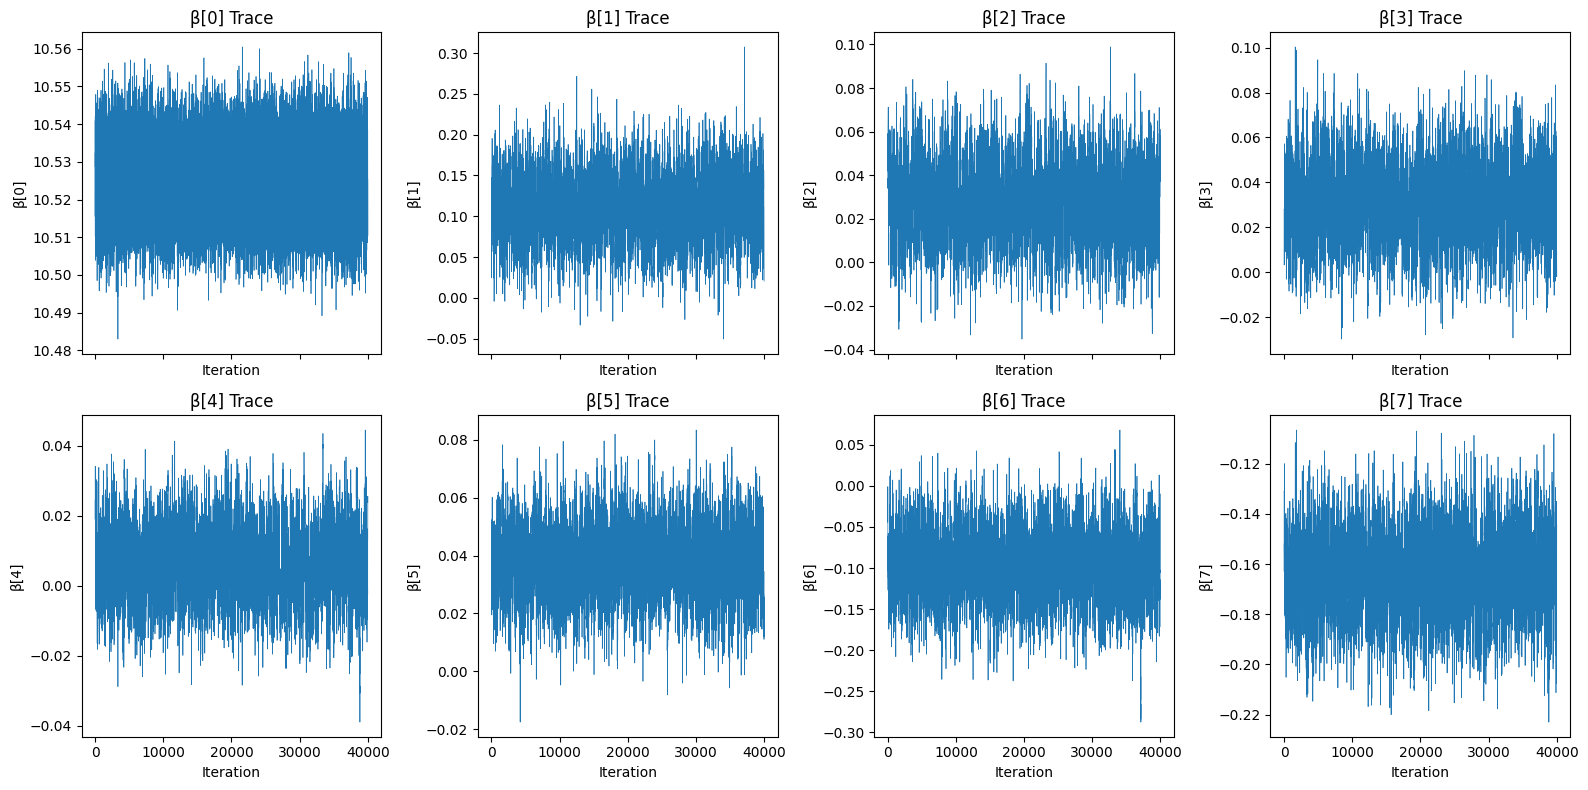

In [8]:
fig = plot_beta_traces(beta_post, ncols=4, figsize=(16, 8))

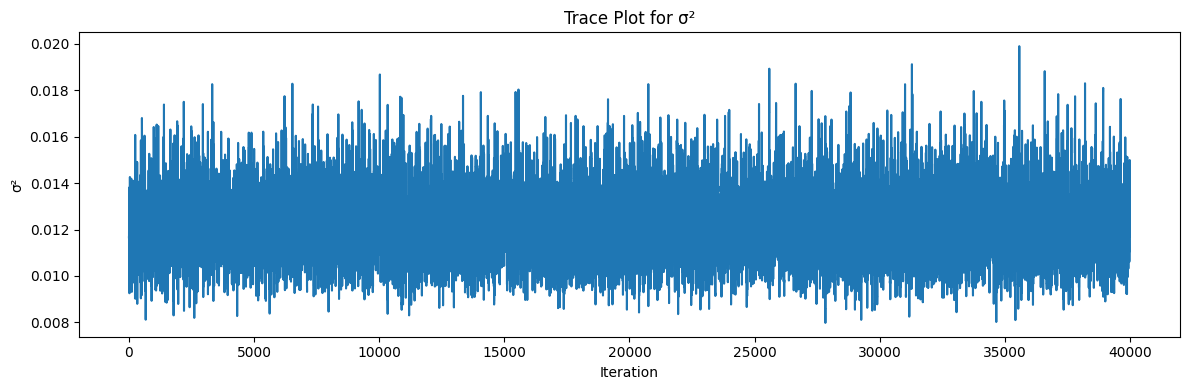

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.plot(sigma_post)
plt.title('Trace Plot for σ²')
plt.xlabel('Iteration')
plt.ylabel('σ²')
plt.tight_layout()
plt.show()

In [9]:
rep = mcmc_efficiency_report(
    beta_post,
    param_prefix="β",
    max_lag=200,  
    rank_by="ess",
    top_k=8)

display(rep["table"])  
display(rep["worst"])  

,n_chains,n_draws_per_chain,tau_mean,tau_max,ess_mean,ess_min,ess_frac_min,K_used_mean
parameter,,,,,,,,
β[0],1,40000,1.023272,1.023272,39090.280429,39090.280429,0.977257,6.0
β[1],1,40000,23.344316,23.344316,1713.479239,1713.479239,0.042837,48.0
β[2],1,40000,25.995536,25.995536,1538.725743,1538.725743,0.038468,54.0
β[3],1,40000,27.905784,27.905784,1433.394620,1433.394620,0.035835,106.0
β[4],1,40000,24.184953,24.184953,1653.920898,1653.920898,0.041348,90.0
β[5],1,40000,26.122556,26.122556,1531.243755,1531.243755,0.038281,94.0
β[6],1,40000,23.197195,23.197195,1724.346386,1724.346386,0.043109,52.0
β[7],1,40000,22.927660,22.927660,1744.617610,1744.617610,0.043615,46.0


,n_chains,n_draws_per_chain,tau_mean,tau_max,ess_mean,ess_min,ess_frac_min,K_used_mean
parameter,,,,,,,,
β[3],1,40000,27.905784,27.905784,1433.394620,1433.394620,0.035835,106.0
β[5],1,40000,26.122556,26.122556,1531.243755,1531.243755,0.038281,94.0
β[2],1,40000,25.995536,25.995536,1538.725743,1538.725743,0.038468,54.0
β[4],1,40000,24.184953,24.184953,1653.920898,1653.920898,0.041348,90.0
β[1],1,40000,23.344316,23.344316,1713.479239,1713.479239,0.042837,48.0
β[6],1,40000,23.197195,23.197195,1724.346386,1724.346386,0.043109,52.0
β[7],1,40000,22.927660,22.927660,1744.617610,1744.617610,0.043615,46.0
β[0],1,40000,1.023272,1.023272,39090.280429,39090.280429,0.977257,6.0


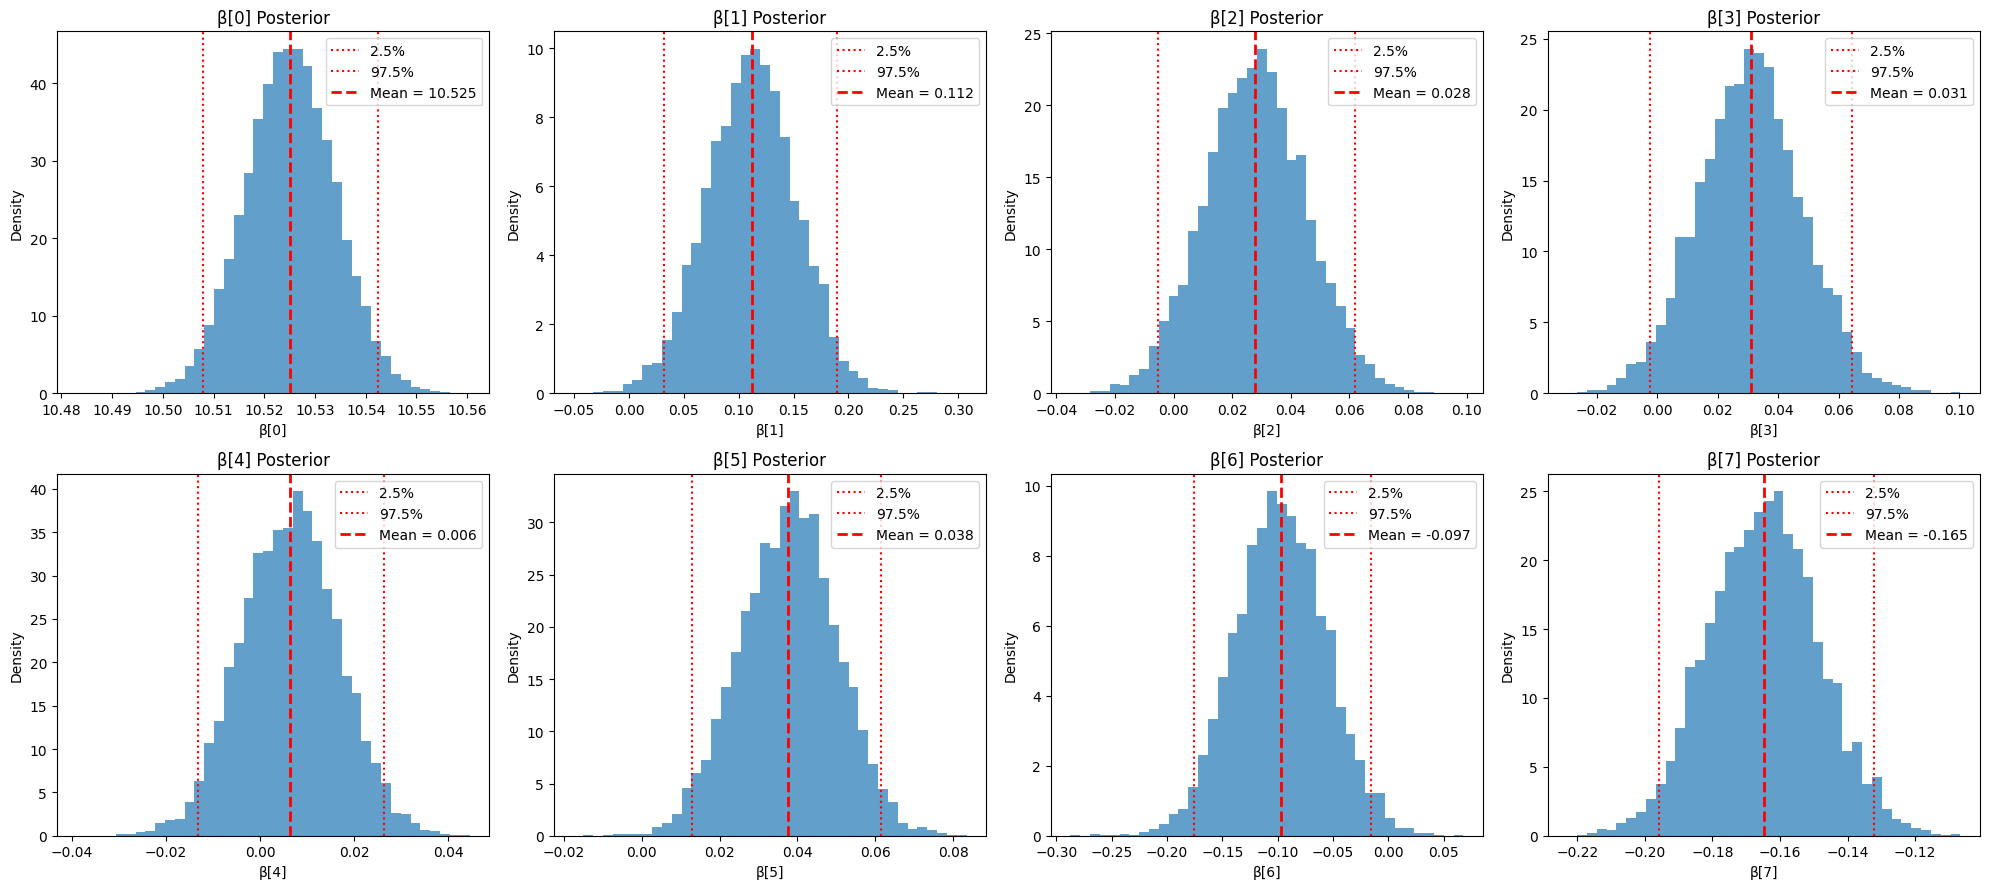

In [10]:
fig = plot_beta_posteriors(beta_post, ncols=4, figsize=(20, 9))

In [11]:
df = summarize_beta_posterior(
    beta_post,
    ci=0.95,
    tests=[{"name":"P(>0)", "fn": lambda s: s > 0}]
)
display(df)

,mean,median,sd,2%,97%,P(>0)
parameter,,,,,,
β[0],10.525154,10.525144,0.008842,10.507865,10.542394,1.000000
β[1],0.111671,0.111754,0.040656,0.032258,0.189586,0.997175
β[2],0.027936,0.027892,0.017213,-0.005266,0.061829,0.946625
β[3],0.030862,0.030824,0.017167,-0.002576,0.064500,0.965025
β[4],0.006402,0.006581,0.010303,-0.013101,0.026398,0.724675
β[5],0.037697,0.038014,0.012459,0.012954,0.061423,0.998750
β[6],-0.097316,-0.097620,0.041079,-0.175786,-0.015189,0.007925
β[7],-0.164704,-0.164596,0.016288,-0.195967,-0.132304,0.000000


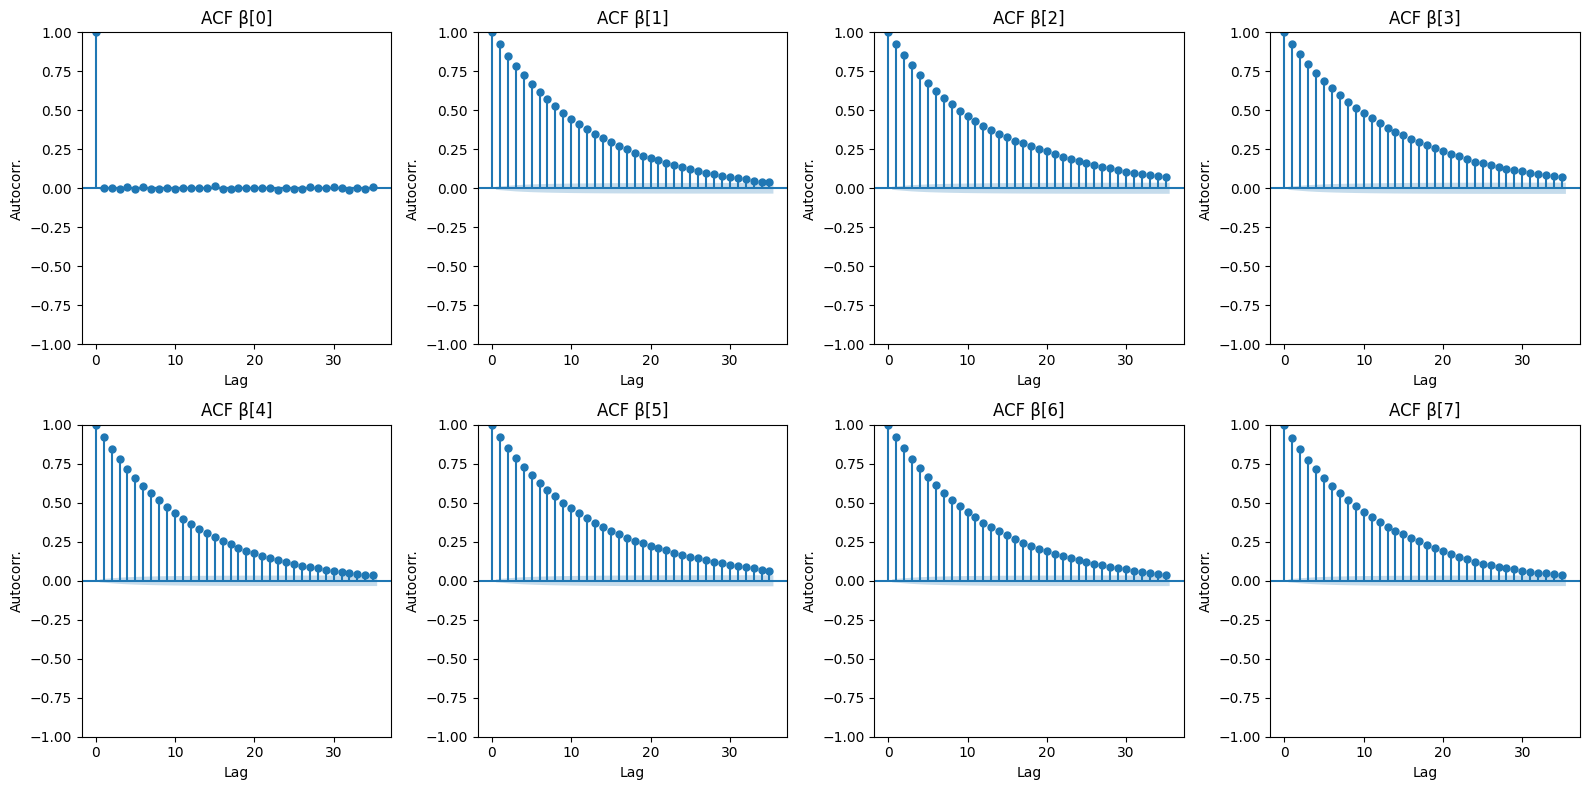

In [13]:
fig = plot_beta_acf(beta_post, lags=35, alpha=0.05, ncols=4, figsize=(16, 8))

--- 

In [14]:
beta2, sigma2= MCMC_LM_beta_nonconj_sigma2_nonconj_adaptcov_slopes(
    X_design, y_log,
    n_draws=n_draws,
    burn_in=burn_in,
    thinning=thinning,
    seed=seed,

    # beta prior
    prior=prior,
    prior_kwargs=prior_kwargs,
    intercept_idx=0,
    gibbs_intercept=True,  

    # sigma2 prior (no conjugado)
    sigma2_prior=sigma2_prior,
    sigma2_prior_kwargs=sigma2_prior_kwargs,

    # init
    beta_init=None,
    sigma2_init=s2_emp,

    # slopes proposal + adaptación
    proposal_scale=0.20,
    ridge=1e-8,
    adapt_scale=True,
    target_accept=0.25,
    adapt_every=100,
    adapt_start=400,
    adapt_gain=2.0,

    # adaptive covariance slopes
    adapt_cov=True,
    cov_start="xtx",
    cov_ridge=1e-6,
    cov_update_every=200,
    cov_start_at=500,

    # sigma2 MH en log(sigma2) + adaptación
    sigma2_prop_scale=0.25,          # tamaño inicial del RW en log(sigma2)
    adapt_sigma2_scale=True,
    target_accept_sigma2=0.44,       # 1D RW óptimo ~0.44
    adapt_sigma2_every=100,
    adapt_sigma2_start=400,
    adapt_sigma2_gain=1.0,

    progress=False,
    progress_every=1000,
    show_time=True,
    return_info=False)



idata = build_idata_from_chains(
    beta_chains=[beta_post, beta2],
    sigma2_chains=[sigma_post, sigma2],
    coef_names=[f"beta_{j}" for j in range(beta_post.shape[1])])

rep = arviz_mcmc_report(
    idata,
    var_names=("beta", "sigma2"),
    hdi_prob=0.95,
    rhat_warn=1.01,
    ess_bulk_warn=400,
    mcse_rel_warn=0.10,)

print(rep["text"])
display(rep["summary"])  

=== MCMC Diagnostics Report (ArviZ) ===
Chains: 2 | Draws per chain: 40000 | Total draws: 80000
HDI prob: 0.95
No red flags under chosen thresholds.
Worst-case diagnostics:
  - worst_rhat: 1.0008
  - worst_rhat_param: beta[beta_4]
  - min_ess_bulk: 2910.7362
  - min_ess_bulk_param: beta[beta_3]
  - min_ess_tail: 4856.7266
  - min_ess_tail_param: beta[beta_3]
  - max_mcse_rel: 0.03125
  - max_mcse_rel_param: beta[beta_4]


c:\Users\alejo\OneDrive\Escritorio\Profesional\Modelaje\Econometria\bayesian-linear-regression\src\analize_chain_convergence.py:142: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_chains = idata.posterior.dims.get("chain", None)
c:\Users\alejo\OneDrive\Escritorio\Profesional\Modelaje\Econometria\bayesian-linear-regression\src\analize_chain_convergence.py:143: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_draws = idata.posterior.dims.get("draw", None)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,mcse_rel
beta[beta_0],10.5252,0.0088,10.5077,10.5422,0.0000,0.0000,79298.4017,77776.5562,1.0000,0.000000
beta[beta_1],0.1117,0.0407,0.0311,0.1881,0.0007,0.0004,3435.2214,6120.6128,1.0001,0.006267
beta[beta_2],0.0279,0.0172,-0.0052,0.0618,0.0003,0.0002,3082.1972,5099.6599,1.0001,0.010753
beta[beta_3],0.0309,0.0172,-0.0031,0.0639,0.0003,0.0002,2910.7362,4856.7266,1.0000,0.009709
beta[beta_4],0.0064,0.0103,-0.0129,0.0265,0.0002,0.0001,3309.7229,5991.3945,1.0008,0.031250
beta[beta_5],0.0377,0.0125,0.0118,0.0601,0.0002,0.0001,3087.0732,4879.0693,1.0001,0.005305
beta[beta_6],-0.0973,0.0411,-0.1774,-0.0176,0.0007,0.0004,3453.5352,5906.1814,1.0000,0.007194
beta[beta_7],-0.1647,0.0163,-0.1949,-0.1316,0.0003,0.0002,3492.7186,5037.6089,1.0001,0.001821
sigma2,0.0121,0.0015,0.0094,0.0150,0.0000,0.0000,14594.1890,19026.3503,1.0000,0.000000


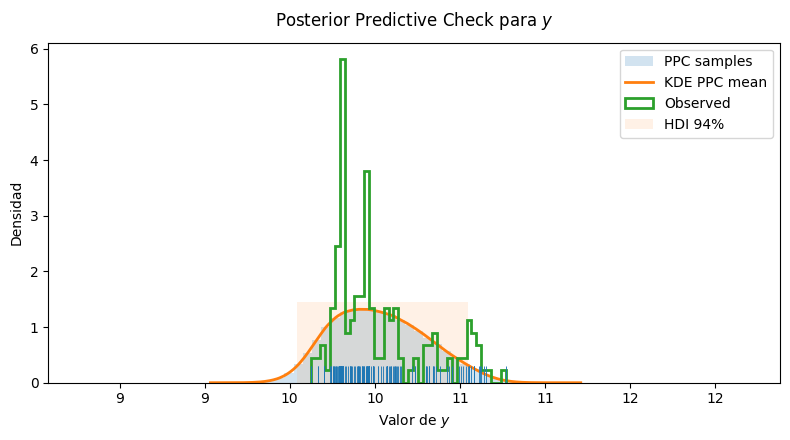

(<Figure size 800x450 with 1 Axes>,
 <Axes: title={'center': 'Posterior Predictive Check para $y$'}, xlabel='Valor de $y$', ylabel='Densidad'>)

In [15]:
idata_ppc = attach_posterior_predictive_y(idata, X_design, seed=123, var_name="y")


plot_ppc_density_y(
    idata=idata_ppc,   
    y=y,
    obs_transform=np.log,
    var_name="y",
    hdi_prob=0.94,
    bins=40)

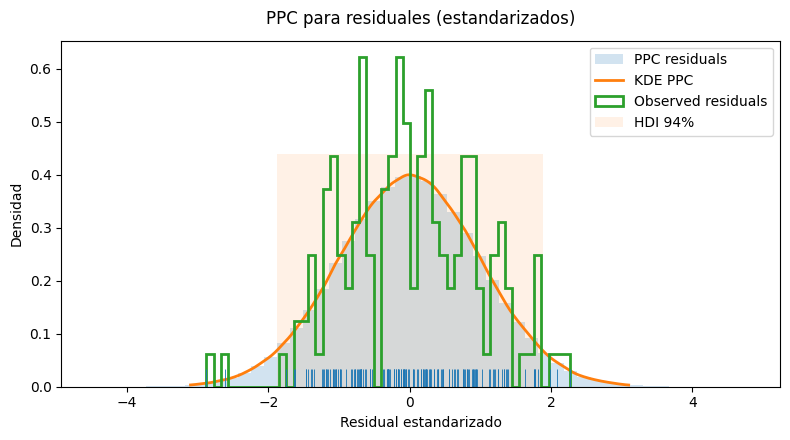

In [16]:
out = plot_ppc_residuals(
    idata=idata_ppc, 
    X=X_design,
    y=y,
    y_transform=np.log,
    standardize=True,
    use_posterior_predictive=True, 
    subsample_draws=3000,
    hdi_prob=0.94,)